<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance


     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=ab78e96f8c2f8f0e8064c2d94934fd0bb17f03f88eb852b5fb60cad7d619e96f
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import plotly.express as px
import plotly.graph_objects as go


In [3]:

import numpy as np
import pandas as pd
import yfinance as yf


In [4]:
nifty=yf.download('^NSEI',start='2018-08-08')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt

In [6]:
content='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [7]:
data1=pd.read_csv(content+'fii1.txt',sep='\t',header=None)
data2=pd.read_csv(content+'fii2.txt',sep='\t',header=None)
data3=pd.read_csv(content+'fii3.txt',sep='\t',header=None)
data4=pd.read_csv(content+'fii4.txt',sep='\t',header=None)
data5=pd.read_csv(content+'fii5.txt',sep='\t',header=None)
data6=pd.read_csv(content+'fii6.txt',sep='\t',header=None)
data7=pd.read_csv(content+'fii7.txt',sep='\t',header=None)
data8=pd.read_csv(content+'fii8.txt',sep='\t',header=None)


In [8]:
data=[]

In [9]:
data=data1[0].tolist()
data.extend(data2[0].tolist())
data.extend(data3[0].tolist())
data.extend(data4[0].tolist())
data.extend(data5[0].tolist())
data.extend(data6[0].tolist())
data.extend(data7[0].tolist())
data.extend(data8[0].tolist())

In [10]:
len(data)

5103

In [11]:
lst=[]
lst.append(data[0:7])

In [12]:
for i in range(7,len(data)):
  if i%7==0:
    #print(i)
    lst.append(data[i:i+7])




In [13]:
df=pd.DataFrame()

In [14]:
for item in lst:
  to_append=item
  a_series = pd.Series(to_append)
  df = df.append(a_series, ignore_index=True)
print(df)

               0      1      2      3       4      5     6
0    30 Jul 2021   3.1     0.3   -356   12951  -3848  2956
1    29 Jul 2021   3.1     0.3   -356   12951   -866  2046
2    28 Jul 2021   3.1     0.3   -356   12951  -2275   921
3    27 Jul 2021  -12.7   53.5   -608   12999  -1459   730
4    26 Jul 2021  -20.3  -21.3     74   11938  -2377  1551
..           ...    ...    ...    ...     ...    ...   ...
724  20 Aug 2018   1.9   -5.6   -118   31185   -483   593 
725  17 Aug 2018  15.6    4.0   -695   30356    147   152 
726  16 Aug 2018  -8.9   11.6   -433   28720   -825   134 
727  14 Aug 2018   3.4    7.7   -711   28727   -379   391 
728  13 Aug 2018  -2.9    1.0   -722   28024   -972   216 

[729 rows x 7 columns]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       729 non-null    object
 1   1       729 non-null    object
 2   2       729 non-null    object
 3   3       729 non-null    object
 4   4       729 non-null    object
 5   5       729 non-null    object
 6   6       729 non-null    object
dtypes: object(7)
memory usage: 40.0+ KB


In [16]:
df.to_csv('fii.csv')

In [17]:
fii_fig= pd.read_csv('/content/fii.csv')

In [18]:
fii_fig=fii_fig[::-1]

In [19]:
fii_fig.tail(2)

,Unnamed: 0,0,1,2,3,4,5,6
1,1,29 Jul 2021,3.1,0.3,-356,12951,-866,2046
0,0,30 Jul 2021,3.1,0.3,-356,12951,-3848,2956


In [20]:
fii_fig.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [21]:
fii_fig.drop('Index',inplace=True,axis=1)

In [22]:
fii_fig=fii_fig.set_index('Date')

In [23]:
fii_fig.tail(3)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
Date,,,,,,
28 Jul 2021,3.1,0.3,-356,12951,-2275,921
29 Jul 2021,3.1,0.3,-356,12951,-866,2046
30 Jul 2021,3.1,0.3,-356,12951,-3848,2956


In [24]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

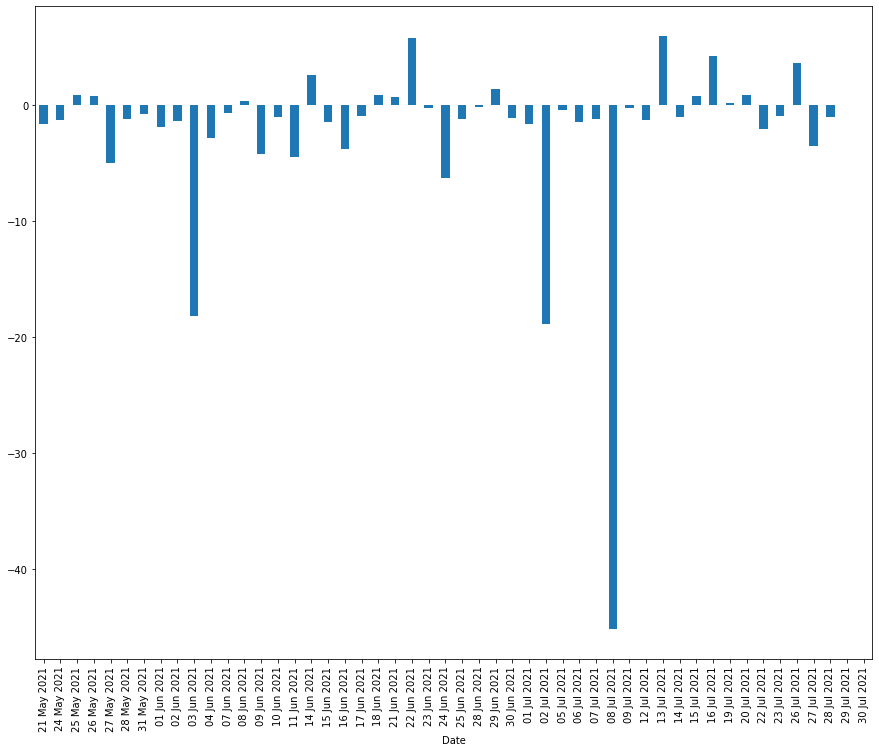

In [25]:
(fii_fig['FIIput'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

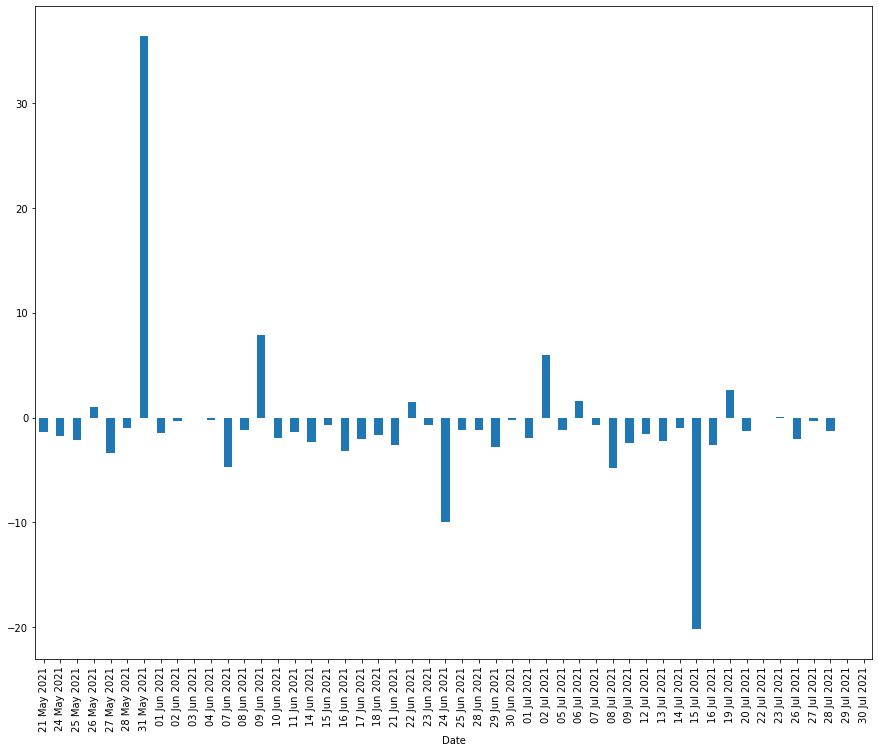

In [26]:
(fii_fig['FIIcall'].pct_change()[-50:]).plot(kind='bar',figsize=(15,12))

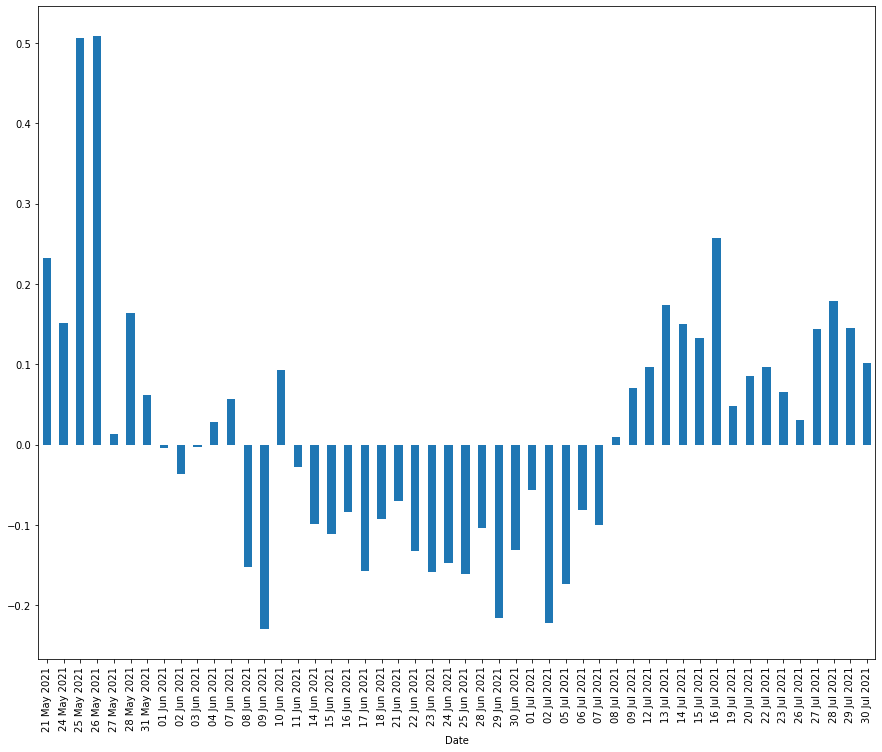

In [27]:
(fii_fig['FIIFutOI'].pct_change(10)[-50:]).plot(kind='bar',figsize=(15,12))


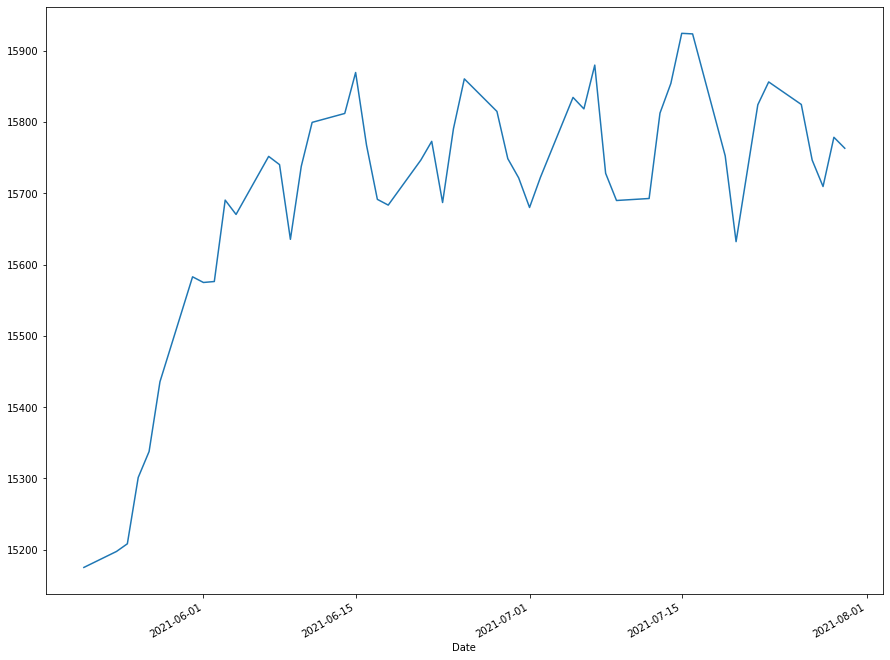

In [28]:
nifty['Close'][-50:].plot(figsize=(15,12))

In [29]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [30]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 

In [31]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=100, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=50,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

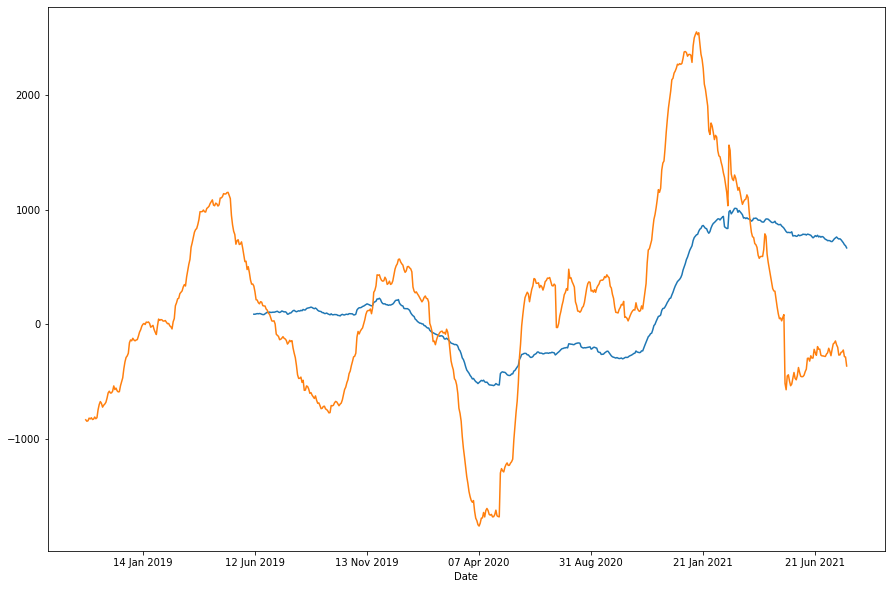

In [32]:
fii_fig.MA200.plot(figsize=(15,10))
fii_fig.MA50.plot()


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['MA200','MA50']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

In [33]:


# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig.show()

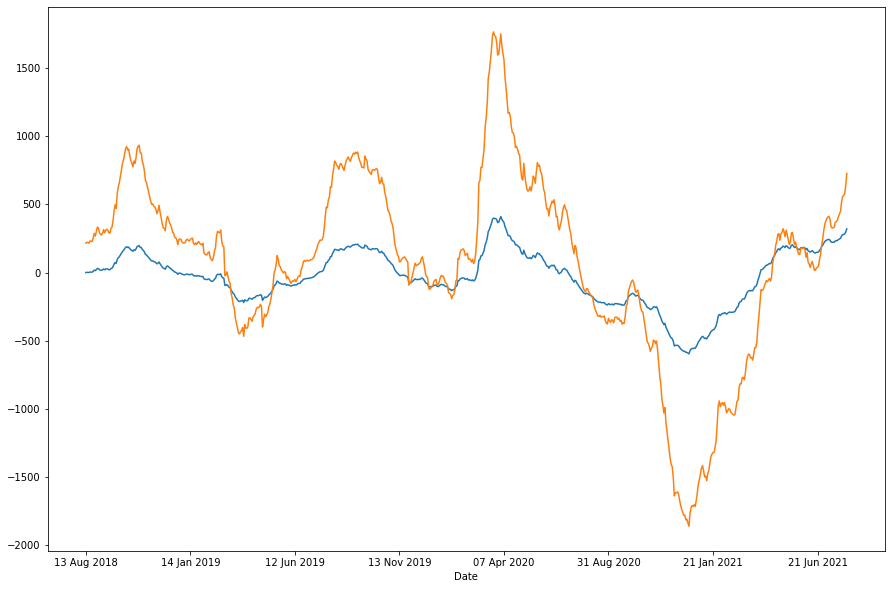

In [34]:
# sample dataset from plotly express
df = fii_fig
# Filter and pivot dataset for each country,
# and add lines for each country
fig1 = go.Figure()
for c in ['macd_dom','signal_dom']:
    fig1.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))

fig1.show()

fii_fig.macd_dom.plot(figsize=(15,10),xlabel='macd')
fii_fig.signal_dom.plot()
plt.show()


In [35]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(height=500, width=900,
                  title_text="Smart Money And Nifty")

fig.show()

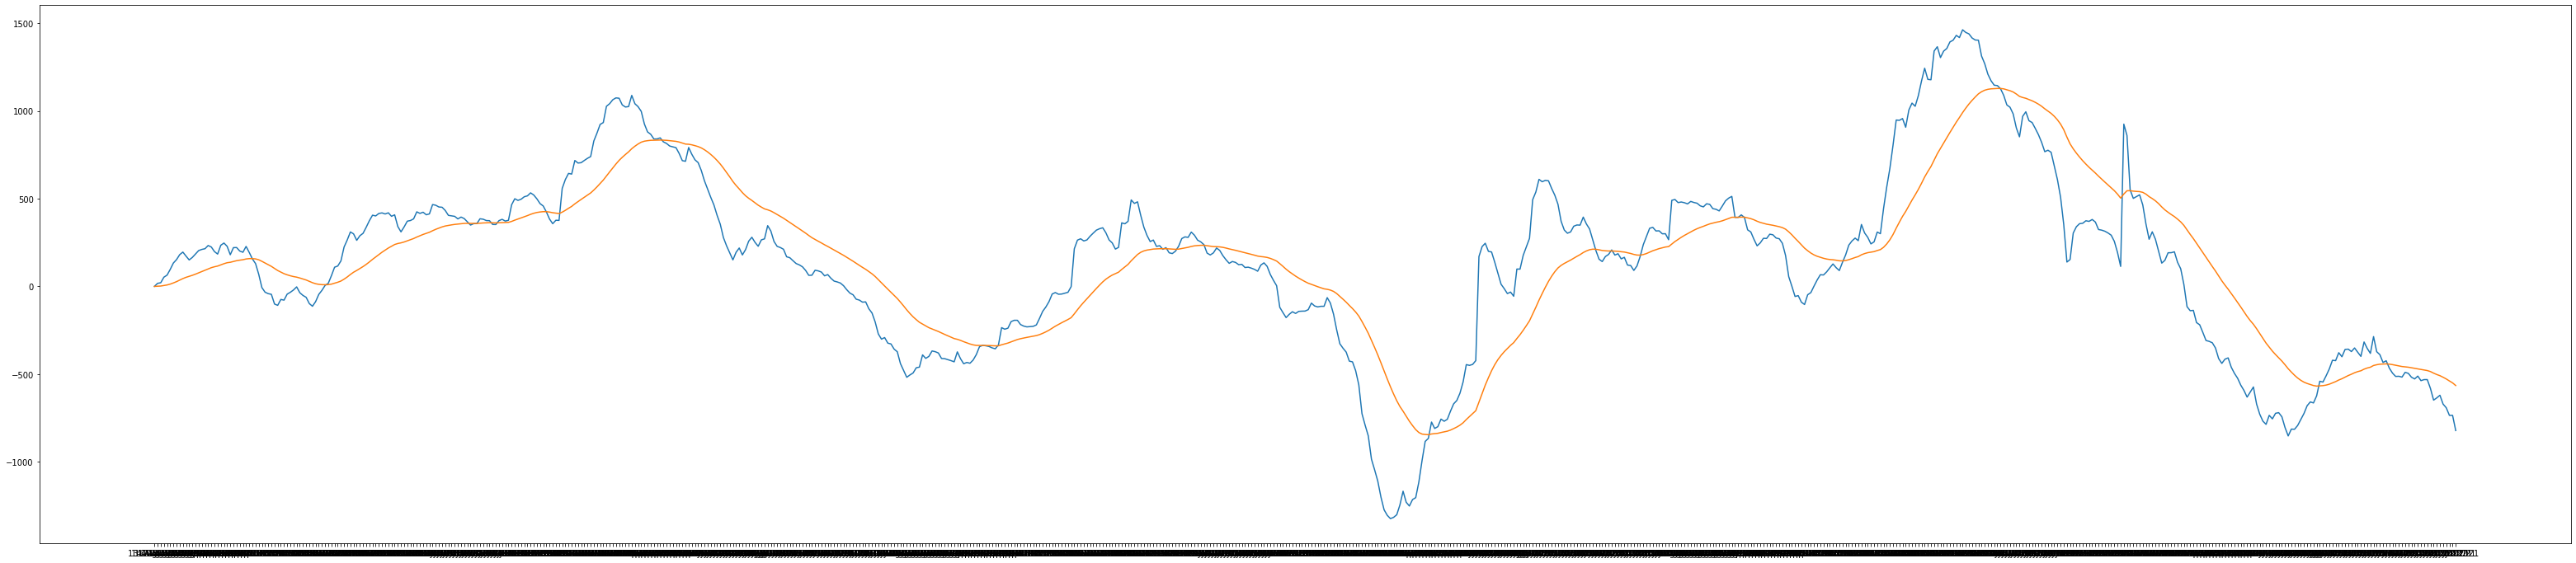

In [36]:
plt.figure(figsize=(55,12))
plt.plot(fii_fig.loc[:, :].index,fii_fig['macd'],label='MACD')
plt.plot(fii_fig.loc[:, :].index,fii_fig['signal'],label='Signal')
#plt.plot(fii_fig.loc[:, :].index)
plt.show()

In [37]:
nifty=nifty.reset_index()

In [38]:
nif.shape,df.macd.shape

((728, 7), (729,))

In [39]:
sample= pd.concat([nif['Close'] ,df['signal']][-len(nif):],axis=1)
sample=sample.replace(0,0.1)

In [40]:
sample['pct_chg']=sample['Close'].pct_change()
sample['macd_chg']=sample['signal'].pct_change()


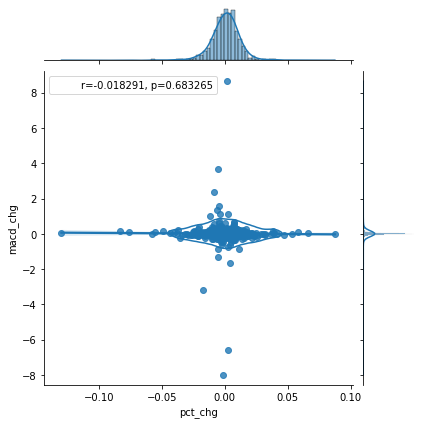

In [41]:
import seaborn as sns
from scipy.stats import pearsonr
g=sns.jointplot(x='pct_chg',y='macd_chg',data=sample,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(sample['pct_chg'][-500:], sample['macd_chg'][-500:])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.show()

In [42]:
df=fii_fig.reset_index()
f=px.line(df,x='Date',y=df['signal_dom'].rolling(window=5).mean())
f.add_scatter(x=df['Date'],y=df['signal_dom'].rolling(window=100).mean(), mode='lines')
f.show()
fi=px.line(nif,x='Date',y='Close')
fi.show()